In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
pd.set_option("display.max_columns", None)
#pd.set_option("display.max_rows", None)
import geopandas as gpd
from nltk import FreqDist
import seaborn as sns
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
#!pip install git+git://github.com/geopandas/geopandas.git
#!apt install proj-bin libproj-dev libgeos-dev
#!pip install git+git://github.com/ResidentMario/geoplot.git

In [3]:
#!pip install geopandas
#!pip install descartes

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
pd.set_option("display.max_columns", None)
import geopandas as gpd
from nltk import FreqDist

In [5]:
fp = "/Users/shashanksingh/Desktop/India_Pollution/01_Data/Analysis/raw_data/GIS_file_of_India_State,_District_and_Tehsil_Boundaries/commondata/ind_adm_shp/IND_adm3.shp"
map_df = gpd.read_file(fp)

In [6]:
#map_df

In [7]:
df_cases = pd.read_csv("/Users/shashanksingh/Desktop/air_pollution/data/processed_data/case_data_final.csv")

In [8]:
#df_cases = pd.read_csv("/Users/shashanksingh/Desktop/India_Pollution/shashank_analysis/processed_data/case_data_final.csv")

In [9]:
len(df_cases)

1502

In [10]:
df_cases = df_cases.drop_duplicates(["Kanoon_ID"], keep = "first")

In [11]:
len(df_cases)

1502

## Analysing overall case data first - 

In [12]:
df_cases["case_present"] = 1

In [13]:
df_plot_orig = df_cases[["district", "case_present", "delivery_year"]]

In [14]:
df_plot = df_plot_orig

In [15]:
map_df["NAME_2"] = map_df["NAME_2"].apply(lambda x : str(x).lower())

In [16]:
list_map_districts = list(map_df["NAME_2"].unique())

In [17]:
from fuzzywuzzy import fuzz

In [18]:
def map_district(string_var):
    cache = 0
    flag = 0
        
    for map_district in list_map_districts:
        score = fuzz.token_set_ratio(string_var, map_district) 
        
        if (score > 90 and score > cache):
            flag = 1
            cache = score
            final_district = map_district
            final_district = final_district.strip()
            
    string_var = string_var.strip()
            
    if flag == 1:
        return final_district
    else:
        return string_var # returning the same district in case of no match

In [19]:
df_plot["map_district"] = df_plot["district"].apply(lambda x : map_district(str(x)))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [20]:
df_plot = df_plot[df_plot["map_district"].notnull()]
df_plot = df_plot.sort_values(["map_district"])
dict_prop = {}
mapped_ds = list(df_plot["map_district"].unique())
for dist in mapped_ds:
    
    df_temp = df_plot[df_plot["map_district"]==dist]
    
    prop = len(df_temp)/len(df_plot)
    
    dict_prop[dist] = prop
    

    
df_plot["proportion"] = df_plot["map_district"].apply(lambda x : dict_prop[x])
df_plot = df_plot.drop_duplicates(["map_district"], keep="first")


In [21]:
merged = pd.merge(map_df,df_plot, left_on = "NAME_2", right_on = "map_district", how = "left")

In [22]:
merged["case_present"] = merged["case_present"].fillna(0)

In [23]:
import tqdm

In [24]:
list_status = []
list_prop = []
for index in tqdm.trange(len(merged)):
    
    poll_present = merged["case_present"][index]
    map_d = str(merged["map_district"][index]).lower()
    prop = merged["proportion"][index]
    
    if(poll_present == 1):
        status = "Case Present"
    
    if(poll_present == 0):
        status = "Case Not Present"
        
    if(map_d == "nan"):
        status = "Case Not Present"
        
    if(str(prop).lower()=="nan"):
        
        list_prop.append(0)
        
    else:
        list_prop.append(prop)
    
    list_status.append(status)

100%|██████████| 2340/2340 [00:00<00:00, 42290.95it/s]


In [25]:
merged["status"] = list_status
merged["proportion"] = list_prop
a = merged[merged["status"] != "Case Not Present"]
len(a["NAME_2"].unique())

243

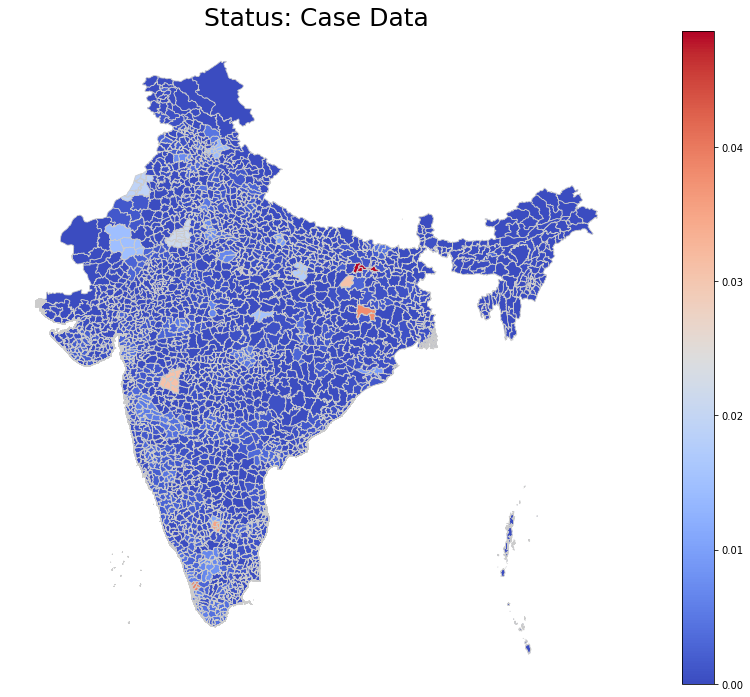

In [26]:
fig, ax = plt.subplots(1, figsize=(20, 12))
ax.axis('off')
ax.set_title('Status: Case Data', fontdict={'fontsize': '25', 'fontweight' : '3'})
merged_yearly = merged
merged.plot(column='proportion', cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
fig.savefig("/Users/shashanksingh/Desktop/air_pollution/results/air_pollution.png")

In [27]:
df_plot_orig["delivery_year"].describe()

count   1497.000
mean    2012.007
std        7.420
min     1981.000
25%     2010.000
50%     2014.000
75%     2018.000
max     2020.000
Name: delivery_year, dtype: float64

In [28]:
#1980-1990
#1990-2000
#2000-2010
#2010-2020

df_plot_80_90 = df_plot_orig[(df_plot_orig["delivery_year"]>1980)&(df_plot_orig["delivery_year"]<=1990)]

df_plot_90_00 = df_plot_orig[(df_plot_orig["delivery_year"]>1990)&(df_plot_orig["delivery_year"]<=2000)]

df_plot_00_10 = df_plot_orig[(df_plot_orig["delivery_year"]>2000)&(df_plot_orig["delivery_year"]<=2010)]

df_plot_10_20 = df_plot_orig[(df_plot_orig["delivery_year"]>2010)&(df_plot_orig["delivery_year"]<=2020)]

In [29]:
df_plot_80_90["map_district"] = df_plot_80_90["district"].apply(lambda x : map_district(str(x)))
df_plot_90_00["map_district"] = df_plot_90_00["district"].apply(lambda x : map_district(str(x)))
df_plot_00_10["map_district"] = df_plot_00_10["district"].apply(lambda x : map_district(str(x)))
df_plot_10_20["map_district"] = df_plot_10_20["district"].apply(lambda x : map_district(str(x)))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [30]:
df_plot_80_90 = df_plot_80_90[df_plot_80_90["map_district"].notnull()]
df_plot_80_90 = df_plot_80_90.sort_values(["map_district"])
dict_prop = {}
mapped_ds = list(df_plot_80_90["map_district"].unique())
for dist in mapped_ds:
    
    df_temp = df_plot_80_90[df_plot_80_90["map_district"]==dist]
    
    prop = len(df_temp)/len(df_plot_80_90)
    
    dict_prop[dist] = prop   
df_plot_80_90["proportion"] = df_plot_80_90["map_district"].apply(lambda x : dict_prop[x])
df_plot_80_90 = df_plot_80_90.drop_duplicates(["map_district"], keep="first")

df_plot_90_00 = df_plot_90_00[df_plot_90_00["map_district"].notnull()]
df_plot_90_00 = df_plot_90_00.sort_values(["map_district"])
dict_prop = {}
mapped_ds = list(df_plot_90_00["map_district"].unique())
for dist in mapped_ds:
    
    df_temp = df_plot_90_00[df_plot_90_00["map_district"]==dist]
    
    prop = len(df_temp)/len(df_plot_90_00)
    
    dict_prop[dist] = prop   
df_plot_90_00["proportion"] = df_plot_90_00["map_district"].apply(lambda x : dict_prop[x])
df_plot_90_00 = df_plot_90_00.drop_duplicates(["map_district"], keep="first")

df_plot_00_10 = df_plot_00_10[df_plot_00_10["map_district"].notnull()]
df_plot_00_10 = df_plot_00_10.sort_values(["map_district"])
dict_prop = {}
mapped_ds = list(df_plot_00_10["map_district"].unique())
for dist in mapped_ds:
    
    df_temp = df_plot_00_10[df_plot_00_10["map_district"]==dist]
    
    prop = len(df_temp)/len(df_plot_00_10)
    
    dict_prop[dist] = prop   
df_plot_00_10["proportion"] = df_plot_00_10["map_district"].apply(lambda x : dict_prop[x])
df_plot_00_10 = df_plot_00_10.drop_duplicates(["map_district"], keep="first")

df_plot_10_20 = df_plot_10_20[df_plot_10_20["map_district"].notnull()]
df_plot_10_20 = df_plot_10_20.sort_values(["map_district"])
dict_prop = {}
mapped_ds = list(df_plot_10_20["map_district"].unique())
for dist in mapped_ds:
    
    df_temp = df_plot_10_20[df_plot_10_20["map_district"]==dist]
    
    prop = len(df_temp)/len(df_plot_10_20)
    
    dict_prop[dist] = prop   
df_plot_10_20["proportion"] = df_plot_10_20["map_district"].apply(lambda x : dict_prop[x])
df_plot_10_20 = df_plot_10_20.drop_duplicates(["map_district"], keep="first")

100%|██████████| 2340/2340 [00:00<00:00, 45524.49it/s]


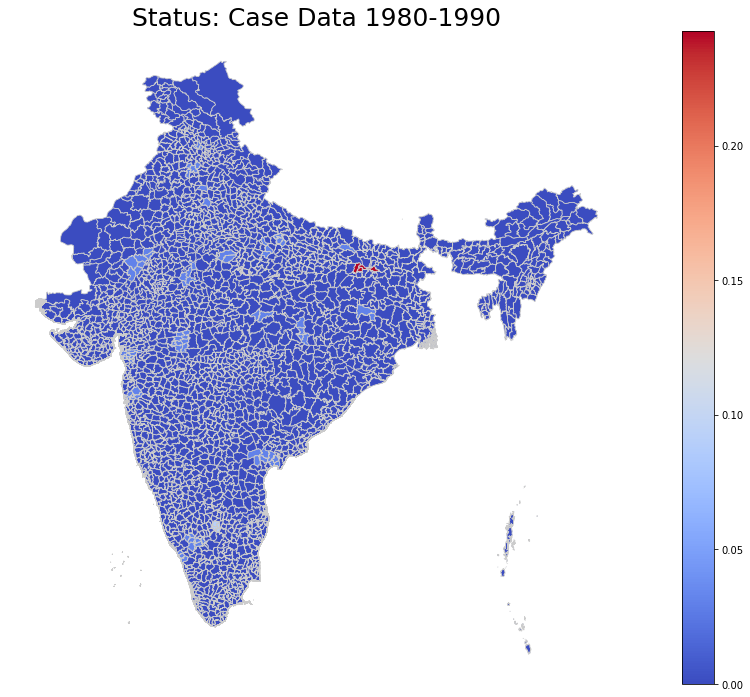

In [31]:
merged = pd.merge(map_df,df_plot_80_90, left_on = "NAME_2", right_on = "map_district", how = "left")

merged["case_present"] = merged["case_present"].fillna(0)

import tqdm

list_status = []
list_prop = []
for index in tqdm.trange(len(merged)):
    
    poll_present = merged["case_present"][index]
    map_d = str(merged["map_district"][index]).lower()
    prop = merged["proportion"][index]
    
    if(poll_present == 1):
        status = "Case Present"
    
    if(poll_present == 0):
        status = "Case Not Present"
        
    if(map_d == "nan"):
        status = "Case Not Present"
        
    if(str(prop).lower()=="nan"):
        
        list_prop.append(0)
        
    else:
        list_prop.append(prop)
    
    list_status.append(status)

merged["status"] = list_status
merged["proportion"] = list_prop
fig, ax = plt.subplots(1, figsize=(20, 12))
ax.axis('off')
ax.set_title('Status: Case Data 1980-1990', fontdict={'fontsize': '25', 'fontweight' : '3'})
merged_yearly = merged
merged.plot(column='proportion', cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
fig.savefig("/Users/shashanksingh/Desktop/air_pollution/results/air_pollution_80_90.png")

100%|██████████| 2340/2340 [00:00<00:00, 41010.83it/s]


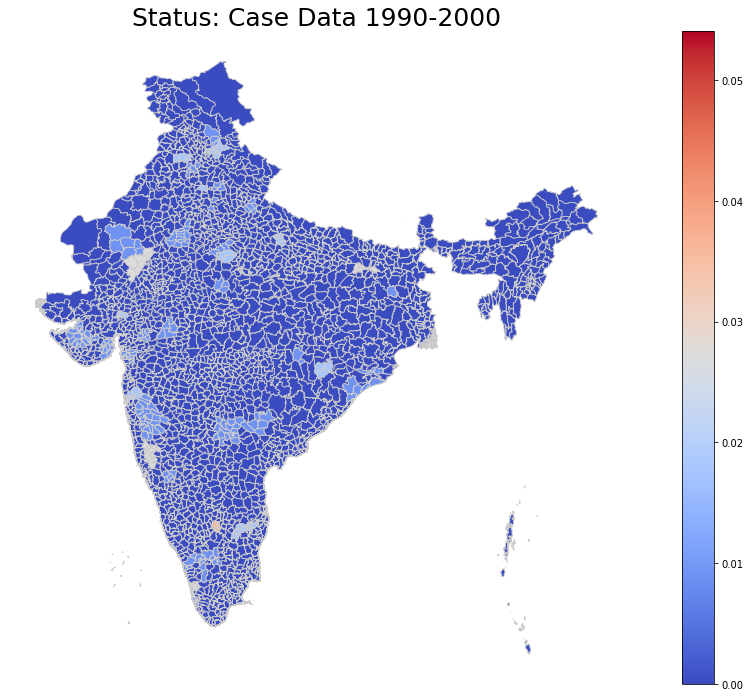

In [32]:
merged = pd.merge(map_df,df_plot_90_00, left_on = "NAME_2", right_on = "map_district", how = "left")

merged["case_present"] = merged["case_present"].fillna(0)

import tqdm

list_status = []
list_prop = []
for index in tqdm.trange(len(merged)):
    
    poll_present = merged["case_present"][index]
    map_d = str(merged["map_district"][index]).lower()
    prop = merged["proportion"][index]
    
    if(poll_present == 1):
        status = "Case Present"
    
    if(poll_present == 0):
        status = "Case Not Present"
        
    if(map_d == "nan"):
        status = "Case Not Present"
        
    if(str(prop).lower()=="nan"):
        
        list_prop.append(0)
        
    else:
        list_prop.append(prop)
    
    list_status.append(status)
    
merged["status"] = list_status
merged["proportion"] = list_prop
fig, ax = plt.subplots(1, figsize=(20, 12))
ax.axis('off')
ax.set_title('Status: Case Data 1990-2000', fontdict={'fontsize': '25', 'fontweight' : '3'})
merged_yearly = merged
merged.plot(column='proportion', cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
fig.savefig("/Users/shashanksingh/Desktop/air_pollution/results/air_pollution_90_00.png")

100%|██████████| 2340/2340 [00:00<00:00, 39293.42it/s]


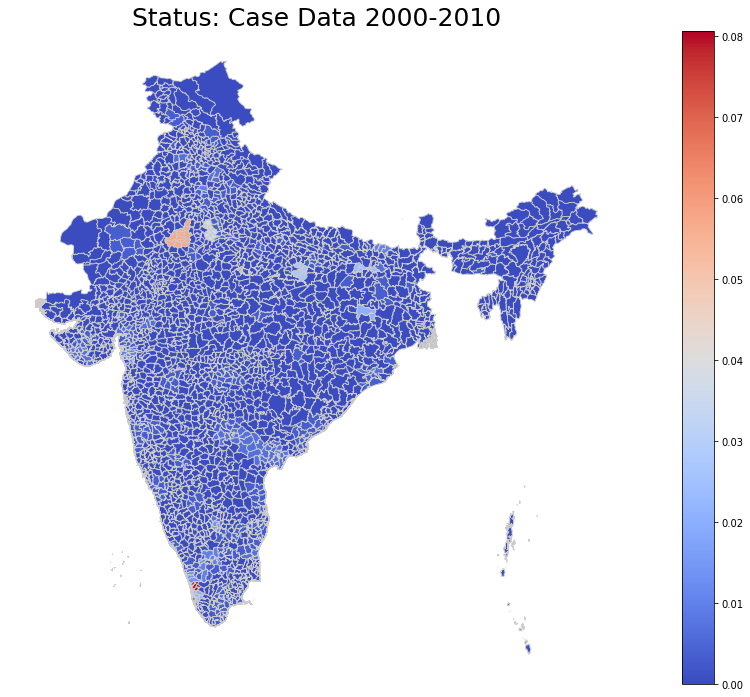

In [33]:
merged = pd.merge(map_df,df_plot_00_10, left_on = "NAME_2", right_on = "map_district", how = "left")

merged["case_present"] = merged["case_present"].fillna(0)

import tqdm

list_status = []
list_prop = []
for index in tqdm.trange(len(merged)):
    
    poll_present = merged["case_present"][index]
    map_d = str(merged["map_district"][index]).lower()
    prop = merged["proportion"][index]
    
    if(poll_present == 1):
        status = "Case Present"
    
    if(poll_present == 0):
        status = "Case Not Present"
        
    if(map_d == "nan"):
        status = "Case Not Present"
        
    if(str(prop).lower()=="nan"):
        
        list_prop.append(0)
        
    else:
        list_prop.append(prop)
    
    list_status.append(status)

merged["status"] = list_status
merged["proportion"] = list_prop
fig, ax = plt.subplots(1, figsize=(20, 12))
ax.axis('off')
ax.set_title('Status: Case Data 2000-2010', fontdict={'fontsize': '25', 'fontweight' : '3'})
merged_yearly = merged
merged.plot(column='proportion', cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
fig.savefig("/Users/shashanksingh/Desktop/air_pollution/results/air_pollution_00_10.png")

100%|██████████| 2340/2340 [00:00<00:00, 27798.25it/s]


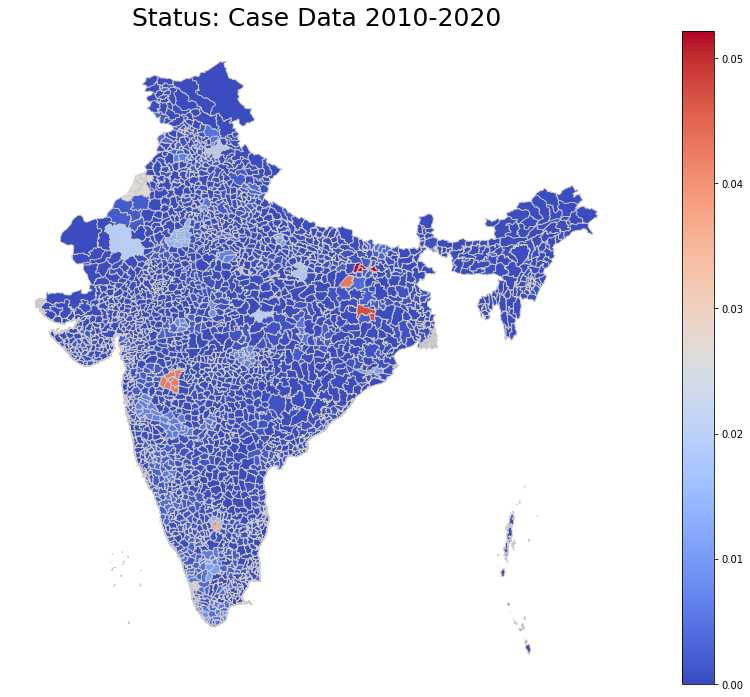

In [34]:
merged = pd.merge(map_df,df_plot_10_20, left_on = "NAME_2", right_on = "map_district", how = "left")

merged["case_present"] = merged["case_present"].fillna(0)

import tqdm

list_status = []
list_prop = []
for index in tqdm.trange(len(merged)):
    
    poll_present = merged["case_present"][index]
    map_d = str(merged["map_district"][index]).lower()
    prop = merged["proportion"][index]
    
    if(poll_present == 1):
        status = "Case Present"
    
    if(poll_present == 0):
        status = "Case Not Present"
        
    if(map_d == "nan"):
        status = "Case Not Present"
        
    if(str(prop).lower()=="nan"):
        
        list_prop.append(0)
        
    else:
        list_prop.append(prop)
    
    list_status.append(status)


merged["status"] = list_status
merged["proportion"] = list_prop

fig, ax = plt.subplots(1, figsize=(20, 12))
ax.axis('off')
ax.set_title('Status: Case Data 2010-2020', fontdict={'fontsize': '25', 'fontweight' : '3'})
merged_yearly = merged
merged.plot(column='proportion', cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
fig.savefig("/Users/shashanksingh/Desktop/air_pollution/results/air_pollution_10_20.png")